# FE + Dimension Reduction + Standardization + ML Classification Model

1. No oversampling techniques applied
2. feature engineering applied

# 1. Import Necessary Libraries

In [1]:
# For Computational and random seed purpose
import numpy as np
np.random.seed(42)
# To read csv file
import pandas as pd
# To Split data into train and cv data
from sklearn.model_selection import train_test_split
# To compute AUROC score
# For AUROC Score (Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
from sklearn.metrics import  roc_curve, auc
# For Hyperparameter and CV Fold
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
# For plot AUROC graph
import matplotlib.pyplot as plt
# Data is umbalance, we need Calibrated Model to ive confidence probabilities result
from sklearn.calibration import CalibratedClassifierCV
# For heatmap
import seaborn as sns
# To ignore warninga
import warnings
warnings.filterwarnings('ignore')
# To stndardize the data
from sklearn.preprocessing import StandardScaler
import tqdm
# Dimension reduction
from sklearn.decomposition import TruncatedSVD

D:\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# 2. Read train data

In [2]:
# Locate parent directory
data_dir = "./"

# Read csv file and display top 5 rows
df_train = pd.read_csv(data_dir+'/train.csv')
df_train.head(5)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [3]:
df_test = pd.read_csv(data_dir+'/test.csv')
df_test.head(5)

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


# 3. Apply Feature Engg

In [4]:
# We already saw in 2_FE.ipynb file that we created a feat_enng function. We just put it here

def feature_engg(df, if_test = False):
    '''
    Perform Feature Engg in Basic Stats, Trigometrics, Hyperbolic and Exponential Function
    
    Parameters:
    df: Pass DataFrame (all features much be in numric values)
    if_test: If the DataFrame is test data or train data. Ig it is test data, put if_test=True
    
    Return:
    DataFrame with feature engineering appended
    '''
    
    if if_test:
        temp = df.drop(['id'], axis=1)
    else:
        temp = df.drop(['id','target'], axis=1)

    # Mean and Std FE
    df['mean'] = np.mean(temp, axis=1)
    df['std'] = np.std(temp, axis=1)

    # Trigometric FE
    sin_temp = np.sin(temp)
    cos_temp = np.cos(temp)
    tan_temp = np.tan(temp)
    df['mean_sin'] = np.mean(sin_temp, axis=1)
    df['mean_cos'] = np.mean(cos_temp, axis=1)
    df['mean_tan'] = np.mean(tan_temp, axis=1)

    # Hyperbolic FE
    sinh_temp = np.sinh(temp)
    cosh_temp = np.cosh(temp)
    tanh_temp = np.tanh(temp)
    df['mean_sinh'] = np.mean(sin_temp, axis=1)
    df['mean_cosh'] = np.mean(cos_temp, axis=1)
    df['mean_tanh'] = np.mean(tan_temp, axis=1)

    # Exponents FE
    exp_temp = np.exp(temp)
    expm1_temp = np.expm1(temp)
    exp2_temp = np.exp2(temp)
    df['mean_exp'] = np.mean(exp_temp, axis=1)
    df['mean_expm1'] = np.mean(expm1_temp, axis=1)
    df['mean_exp2'] = np.mean(exp2_temp, axis=1)

    # Polynomial FE
    # X**2
    df['mean_x2'] = np.mean(np.power(temp,2), axis=1)
    # X**3
    df['mean_x3'] = np.mean(np.power(temp,3), axis=1)
    # X**4
    df['mean_x4'] = np.mean(np.power(temp,4), axis=1)

    return df

In [5]:
df_train = feature_engg(df_train)
df_train.head(5)

,id,target,0,1,2,3,4,5,6,7,...,mean_tan,mean_sinh,mean_cosh,mean_tanh,mean_exp,mean_expm1,mean_exp2,mean_x2,mean_x3,mean_x4
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,-0.315591,-0.010536,0.537968,-0.315591,1.760647,0.760647,1.315869,1.182425,0.015243,3.584848
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,0.607457,0.075490,0.611600,0.607457,1.712292,0.712292,1.324817,0.976056,0.047272,2.766570
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.104777,-0.005509,0.599358,0.104777,1.749107,0.749107,1.313960,1.023024,0.266454,3.092631
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,0.891722,0.046067,0.645721,0.891722,1.752101,0.752101,1.326229,0.887980,0.371308,2.553467
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.274261,0.059548,0.643508,0.274261,1.861741,0.861741,1.377569,0.901115,0.613952,2.671541


In [6]:
df_test = feature_engg(df_test, True)
df_test.head(5)

,id,0,1,2,3,4,5,6,7,8,...,mean_tan,mean_sinh,mean_cosh,mean_tanh,mean_exp,mean_expm1,mean_exp2,mean_x2,mean_x3,mean_x4
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,0.565830,0.094378,0.609398,0.565830,1.904397,0.904397,1.404195,0.985912,0.477020,2.913247
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-1.641918,-0.018425,0.570495,-1.641918,1.642217,0.642217,1.265487,1.094274,-0.128315,3.281111
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.516155,-0.012641,0.611053,-0.516155,1.517775,0.517775,1.214393,0.994294,-0.330590,3.062801
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.816079,0.002689,0.610619,-0.816079,1.566765,0.566765,1.243412,0.956136,-0.076546,2.382968
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,-1.547172,0.067329,0.611907,-1.547172,1.849024,0.849024,1.374870,0.988710,0.371320,3.079160


# 4. Take train and test values from DataFrame

In [7]:
# Take separate for features value
tr_X = df_train.drop(['id','target'], axis=1)
# Take separate for class value
tr_y = df_train['target'].values
# Take test feature value
ts_X = df_test.drop(['id'], axis=1)

Note: Don't worry about splitting train data into train and cv. I apply Stratify CV technique while modelling

# 5. Truncated SVD

In [8]:
exp_rat = []
for i in range(2,min(tr_X.shape[0],tr_X.shape[1])):
    trunsvd = TruncatedSVD(n_components=i)
    trunsvd.fit(tr_X,tr_y)
    exp_rat.append(np.sum(trunsvd.explained_variance_ratio_))

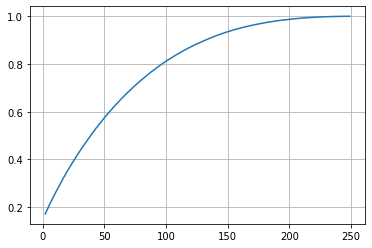

In [9]:
plt.plot(np.arange(2,min(tr_X.shape[0],tr_X.shape[1])),exp_rat)
plt.grid()
plt.show()

Let take n_components = 175 which retain 90-100% data

In [10]:
# Fit and transform on train data and transform on cv and test data
trunsvd = TruncatedSVD(n_components=175)
tr_X = trunsvd.fit_transform(tr_X,tr_y)
ts_X = trunsvd.transform(ts_X)

# 6. Standardization

In [11]:
stand_vec = StandardScaler()
tr_X = stand_vec.fit_transform(tr_X)
pd.DataFrame(tr_X).head(5)

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,-0.164532,0.487939,0.711550,1.063592,0.288814,0.679757,1.419163,-1.929692,1.662674,-1.552939,...,0.674197,-0.500293,2.319579,-0.841767,0.446332,1.842349,-0.889885,-0.612941,0.451177,-1.408989
1,0.032834,0.345192,0.684653,-0.683363,-1.071050,1.601912,-1.389540,-0.982794,-1.583500,0.530116,...,1.159822,-0.080116,0.458993,1.577653,-1.188102,0.410867,-2.342873,0.429029,-0.071122,1.187568
2,-0.042842,-1.009867,0.774578,0.258092,-1.530399,0.864581,-1.308243,-1.458523,1.559741,-0.128236,...,-0.325688,-0.212428,-0.324620,-1.406312,-0.265334,-0.870585,0.072708,0.596910,-0.163540,-0.186299
3,0.086111,-0.816340,-0.788503,0.657952,-0.141692,-1.418505,0.069040,1.360545,-0.419088,1.069888,...,-0.649263,0.210520,-0.117820,0.526989,-1.687033,0.003238,-0.373623,0.490749,1.195760,1.715022
4,-0.047900,0.107642,0.455264,0.929138,0.073400,1.730522,0.176378,-1.868323,-0.005129,0.789978,...,0.102664,-0.797968,-0.681129,1.251984,-1.929878,0.592734,0.444313,-1.195970,-0.398205,-0.075411


In [12]:
ts_X = stand_vec.transform(ts_X)
pd.DataFrame(ts_X).head(5)

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,0.014912,-0.741837,0.274744,-0.063368,-0.432929,0.152815,-0.069140,0.272741,-0.981800,0.261619,...,-0.440932,2.019409,-0.674286,0.248574,0.172730,-0.201424,-0.133651,-0.679212,2.584033,-2.775280
1,-0.366959,-0.919499,-0.443526,0.626691,-0.076199,-0.502496,-0.784105,-0.332528,0.016349,0.193139,...,-3.586539,1.506607,1.235645,1.952467,0.481643,2.181453,0.265854,-0.255515,1.209500,2.050327
2,-0.178551,-0.651318,0.401148,-0.862620,0.579046,0.174308,-0.264050,-0.387602,1.146149,-0.298789,...,3.199833,0.978812,0.296180,0.984599,-1.230266,0.013612,-0.227200,-2.038692,0.130845,-0.244971
3,-0.226939,-1.074750,0.992441,-0.586995,0.002888,-0.118334,0.307092,-0.535269,0.015127,-0.167287,...,-0.924251,0.810002,0.241974,-1.006728,-0.351655,1.283195,-1.792211,3.315743,-4.006598,1.562571
4,-0.330429,-0.465384,-0.621555,-1.089506,-1.306731,-0.059321,0.148408,-0.022165,0.001760,-0.500889,...,-1.122691,0.482733,-2.019647,-0.426909,0.752649,0.194994,0.969147,-2.318632,2.219397,1.524134


# 7. Apply ML Models (with hyperparameter)

In [13]:
def hyperparameter_model(models, params):
    '''
    Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by CalibratedClassifier
    
    Parameters:
    models: Instance of the model
    params: list of parameters with value fr tuning (dict)
    
    Return:
    grid_clf: return gridsearch model    
    '''
    # Random shuffle after every iteration with stratify
    str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    # Find the right hyperparameter for the model
    grid_clf = GridSearchCV(models, params, cv=str_cv, return_train_score=True, scoring='roc_auc')
    # Fit on train data
    grid_clf.fit(tr_X, tr_y)
    return grid_clf

# 7.1 kNN

In [14]:
# Import KNN
from sklearn.neighbors import KNeighborsClassifier

In [15]:
# kNN (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

# List of params
params = {'n_neighbors':np.arange(3,51,2).tolist(), 'algorithm': ['kd_tree', 'brute']}
# Instance of knn model
knn_model = KNeighborsClassifier()
# Call hyperparameter for find the best params as possible
knn_clf = hyperparameter_model(knn_model, params)

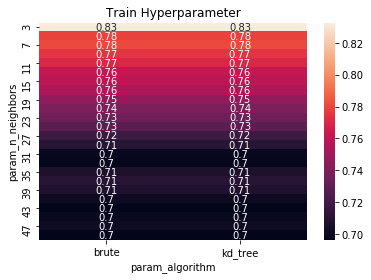

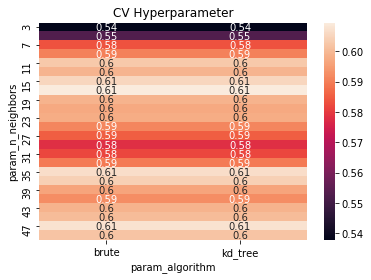

In [16]:
cv_pvt = pd.pivot_table(pd.DataFrame(knn_clf.cv_results_), values='mean_test_score', index='param_n_neighbors', \
                     columns='param_algorithm')
tr_pvt = pd.pivot_table(pd.DataFrame(knn_clf.cv_results_), values='mean_train_score', index='param_n_neighbors', \
                     columns='param_algorithm')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [17]:
print(knn_clf.best_params_)

clf = CalibratedClassifierCV(knn_clf, cv=3)
clf.fit(tr_X,tr_y)

{'algorithm': 'kd_tree', 'n_neighbors': 17}


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=KNeighborsClassifier(algorithm='auto',
                                                                                  leaf_size=30,
                                                                                  metric='minkowski',
                                                                                  metric_params=None,
                                                                                  n_jobs=None,
                                                                                  n_neighbors=5,
                                                                                  p=2,
                                                                                  weights='uniform'),
                             

# 7.1.1 Kaggle Score

In [18]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
knn_csv = clf.predict_proba(ts_X)[:,1]
knn_df = pd.DataFrame(np.column_stack((temp_id,knn_csv)), columns=['id','target'])
knn_df['id'] = knn_df['id'].astype('int32')
knn_df.to_csv(data_dir+'/submission_knn_tr175.csv', index=False)

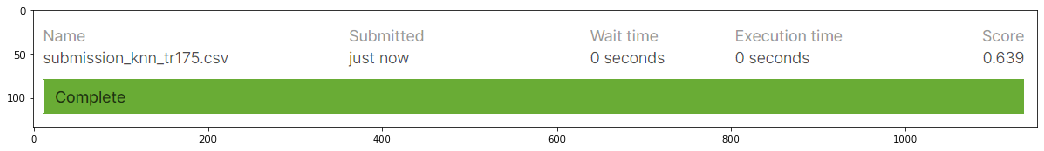

In [43]:
image = plt.imread(data_dir+'/submission_knn_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

## 7.2 Logistic Regression

In [19]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

In [20]:
# LogisticRegression (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

# List of hyperparameter that has to be tuned
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag']}
# Instance of Logsitic Regression
log_model = LogisticRegression(random_state=42, class_weight='balanced')
# Call hyperparameter to get the best parameters of this model
log_clf = hyperparameter_model(log_model, params)

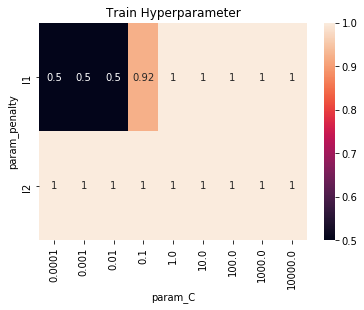

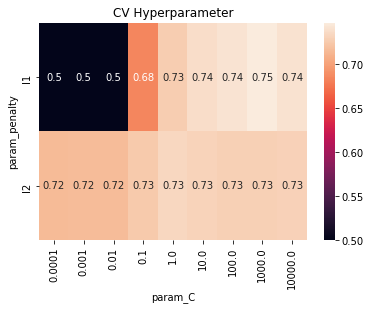

In [21]:
cv_pvt = pd.pivot_table(pd.DataFrame(log_clf.cv_results_), values='mean_test_score', index='param_penalty', \
                     columns='param_C')
tr_pvt = pd.pivot_table(pd.DataFrame(log_clf.cv_results_), values='mean_train_score', index='param_penalty', \
                     columns='param_C')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [22]:
print(log_clf.best_params_)

clf = CalibratedClassifierCV(log_clf, cv=3)
clf.fit(tr_X,tr_y)

{'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=LogisticRegression(C=1.0,
                                                                                class_weight='balanced',
                                                                                dual=False,
                                                                                fit_intercept=True,
                                                                                intercept_scaling=1,
                                                                                l1_ratio=None,
                                                                                max_iter=100,
                                                                                multi_class='auto',
                                    

# 7.2.1 Kaggle Score

In [23]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
log_csv = clf.predict_proba(ts_X)[:,1]
log_df = pd.DataFrame(np.column_stack((temp_id,log_csv)), columns=['id','target'])
log_df['id'] = log_df['id'].astype('int32')
log_df.to_csv(data_dir+'/submission_log_tr175.csv', index=False)

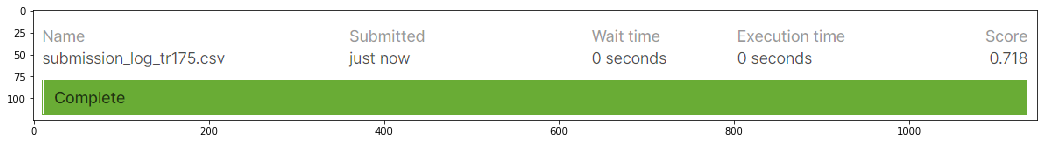

In [44]:
image = plt.imread(data_dir+'/submission_log_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 7.3 SVC

In [24]:
# Import SVC
from sklearn.svm import SVC

In [26]:
# SVC (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

# List of hyperparameter that has to be tuned
params = {'C':[10**i for i in range(-4,5)], 'kernel':['linear','poly','sigmoid','rbf']}
# Instance of SVC
svc_model = SVC(class_weight='balanced', random_state=42, probability=True)
# Call hyperparameter to find the best parameters
svc_clf = hyperparameter_model(svc_model, params)

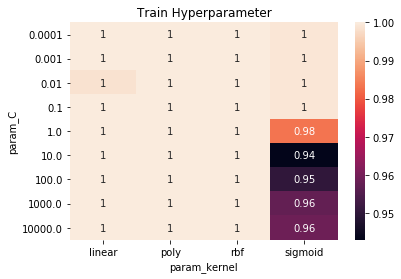

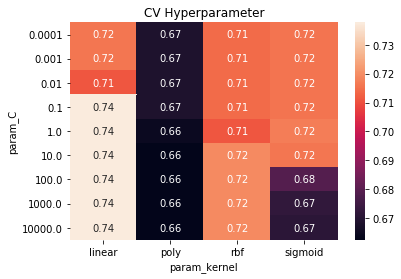

In [27]:
cv_pvt = pd.pivot_table(pd.DataFrame(svc_clf.cv_results_), values='mean_test_score', index='param_C', \
                     columns='param_kernel')
tr_pvt = pd.pivot_table(pd.DataFrame(svc_clf.cv_results_), values='mean_train_score', index='param_C', \
                     columns='param_kernel')

plt.title('Train Hyperparameter')
sns.heatmap(tr_pvt, annot=True)
plt.show()

plt.title('CV Hyperparameter')
sns.heatmap(cv_pvt, annot=True)
plt.show()

In [28]:
print(svc_clf.best_params_)

clf = CalibratedClassifierCV(svc_clf, cv=3)
clf.fit(tr_X,tr_y)

{'C': 0.1, 'kernel': 'linear'}


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=SVC(C=1.0,
                                                                 break_ties=False,
                                                                 cache_size=200,
                                                                 class_weight='balanced',
                                                                 coef0=0.0,
                                                                 decision_function_shape='ovr',
                                                                 degree=3,
                                                                 gamma='scale',
                                                                 kernel='rbf',
                                                                 max_iter=-1,


# 7.3.1 Kaggle Score

In [29]:
# Create a submssion format to make submission in Kaggle
temp_id = df_test['id']
svc_csv = clf.predict_proba(ts_X)[:,1]
svc_df = pd.DataFrame(np.column_stack((temp_id,svc_csv)), columns=['id','target'])
svc_df['id'] = svc_df['id'].astype('int32')
svc_df.to_csv(data_dir+'/submission_svc_tr75.csv', index=False)

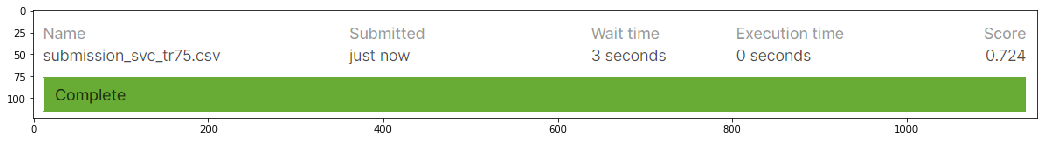

In [45]:
image = plt.imread(data_dir+'/submission_svc_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 7.4 RandomForest

In [30]:
# Impoer Random Forest
from sklearn.ensemble import RandomForestClassifier

In [31]:
# RandomForest (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

# List of hyperparameter that has t be tuned
params = {'n_estimators':[10,20,30,40,50,100,200,300,400],'max_depth':[2,3,5,7]}
# Instance of randomforest
rf_model = RandomForestClassifier(random_state=42)
# Perform GridSearchCV to find best parameters
rf_clf = hyperparameter_model(rf_model, params)

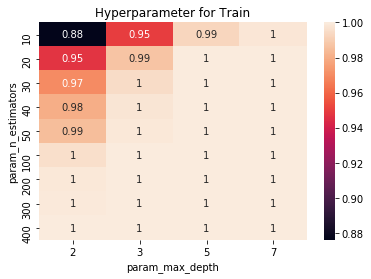

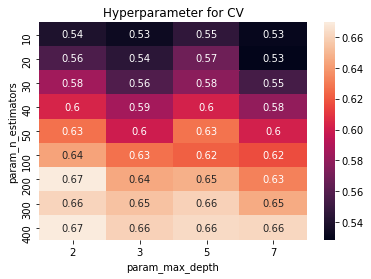

In [32]:
# Ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

# Plotting of hyperpameter of train and cv score
pvt_tr = pd.pivot_table(pd.DataFrame(rf_clf.cv_results_), values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
pvt_cv = pd.pivot_table(pd.DataFrame(rf_clf.cv_results_), values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
plt.figure(1)
plt.title('Hyperparameter for Train')
sns.heatmap(pvt_tr, annot=True)
plt.figure(2)
plt.title('Hyperparameter for CV')
sns.heatmap(pvt_cv, annot=True)
plt.show()

In [33]:
print(rf_clf.best_params_)

# Calibrate the model
clf = CalibratedClassifierCV(rf_clf, cv=3)
clf.fit(tr_X, tr_y)

{'max_depth': 2, 'n_estimators': 400}


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=RandomForestClassifier(bootstrap=True,
                                                                                    ccp_alpha=0.0,
                                                                                    class_weight=None,
                                                                                    criterion='gini',
                                                                                    max_depth=None,
                                                                                    max_features='auto',
                                                                                    max_leaf_nodes=None,
                                                                                    max_samples=

# 7.4.1 Kaggle Score

In [34]:
# Create a submission file format to submit in kaggle
temp_id = df_test['id']
rf_csv = clf.predict_proba(ts_X)[:,1]
rf_df = pd.DataFrame(np.column_stack((temp_id,rf_csv)), columns=['id','target'])
rf_df['id'] = rf_df['id'].astype('int32')
rf_df.to_csv(data_dir+'/submission_rf_tr175.csv', index=False)

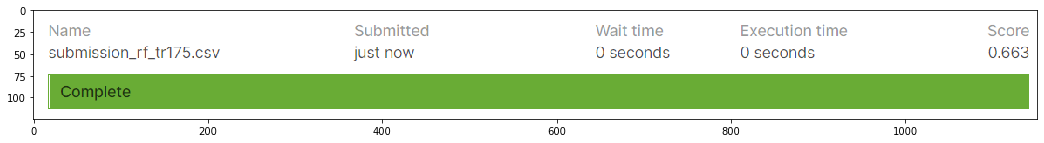

In [46]:
image = plt.imread(data_dir+'/submission_rf_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 7.5 XGBoost

In [35]:
# Import Xgboost
from xgboost import XGBClassifier

In [36]:
# Xgboost (See Docs: https://xgboost.readthedocs.io/en/latest/python/python_api.html)

# List of hyperparameter that has to be tuned
params = {'max_depth':[2,3,5,7], 'n_estimators':[10,20,50,100,200,300,400]}
# Instance of XGBoost Model
xgb_model = XGBClassifier(scale_pos_weight=0.5)
# Call hyperparameter to find the best parameters
xgb_clf = hyperparameter_model(xgb_model, params)

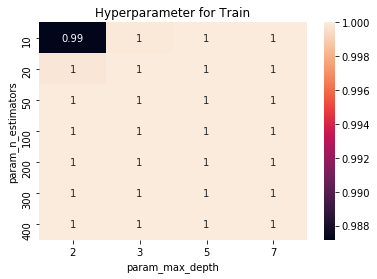

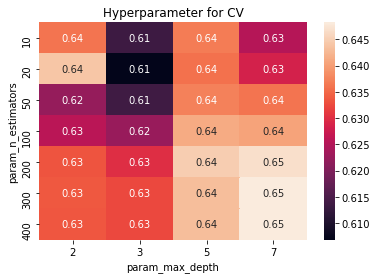

In [37]:
# Ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

# Plotting of hyperpameter of train and cv score
pvt_tr = pd.pivot_table(pd.DataFrame(xgb_clf.cv_results_), values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
pvt_cv = pd.pivot_table(pd.DataFrame(xgb_clf.cv_results_), values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
plt.figure(1)
plt.title('Hyperparameter for Train')
sns.heatmap(pvt_tr, annot=True)
plt.figure(2)
plt.title('Hyperparameter for CV')
sns.heatmap(pvt_cv, annot=True)
plt.show()

In [38]:
print(xgb_clf.best_params_)

# Calibrate the model
clf = CalibratedClassifierCV(xgb_clf, cv=3)
clf.fit(tr_X, tr_y)

{'max_depth': 7, 'n_estimators': 300}


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=XGBClassifier(base_score=None,
                                                                           booster=None,
                                                                           colsample_bylevel=None,
                                                                           colsample_bynode=None,
                                                                           colsample_bytree=None,
                                                                           gamma=None,
                                                                           gpu_id=None,
                                                                           importance_type='gain',
                                                            

# 7.5.1 Kaggle Score

In [39]:
# Create submission file format to submit in Kaggle
temp_id = df_test['id']
xgb_csv = clf.predict_proba(ts_X)[:,1]
xgb_df = pd.DataFrame(np.column_stack((temp_id,xgb_csv)), columns=['id','target'])
xgb_df['id'] = xgb_df['id'].astype('int32')
xgb_df.to_csv(data_dir+'/submission_xgb_tr175.csv', index=False)

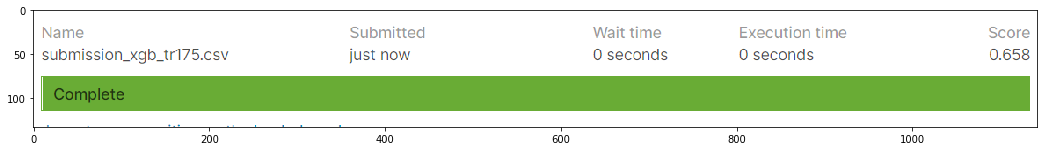

In [47]:
image = plt.imread(data_dir+'/submission_xgb_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 7.6 Stacking Classifier

In [40]:
# Import Stacking Classifier
from mlxtend.classifier import StackingClassifier

In [41]:
# StackClassifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#methods)

# Classifier 1: Logistic Regression with best params
clf1 = LogisticRegression(C = 1000, penalty = 'l1', solver = 'liblinear', class_weight='balanced', random_state=42)
clf1.fit(tr_X,tr_y)
clf1 = CalibratedClassifierCV(clf1, cv=3)

# Classifier 2: SVC with best params
clf2 = SVC(C=0.1, kernel='linear', random_state=42, class_weight='balanced', probability=True)
clf2.fit(tr_X,tr_y)
clf2 = CalibratedClassifierCV(clf2, cv=3)

# Classifier 3: XGBoost with best params
clf3 = XGBClassifier(max_depth=7, n_estimators=300, scale_pos_weight=0.5)
clf3.fit(tr_X,tr_y)
clf3 = CalibratedClassifierCV(clf3, cv=3)

# Classifier 4: RF with best params
clf4 = RandomForestClassifier(max_depth=2, n_estimators=400)
clf4.fit(tr_X,tr_y)
clf4 = CalibratedClassifierCV(clf4, cv=3)

# Stack Classifier
sclf = StackingClassifier(classifiers=[clf1,clf2,clf3,clf4], meta_classifier=clf1, use_probas=True)

# Fit the model
sclf.fit(tr_X, tr_y)

StackingClassifier(average_probas=False,
                   classifiers=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1000,
                                                                                         class_weight='balanced',
                                                                                         dual=False,
                                                                                         fit_intercept=True,
                                                                                         intercept_scaling=1,
                                                                                         l1_ratio=None,
                                                                                         max_iter=100,
                                                                                         multi_class='auto',
                                                                                         n_jobs=None,
          

# 7.6.1 Kaggle score

In [42]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
sclf_csv = sclf.predict_proba(ts_X)[:,1]
sclf_df = pd.DataFrame(np.column_stack((temp_id,sclf_csv)), columns=['id','target'])
sclf_df['id'] = sclf_df['id'].astype('int32')
sclf_df.to_csv(data_dir+'/submission_sclf_tr175.csv', index=False)

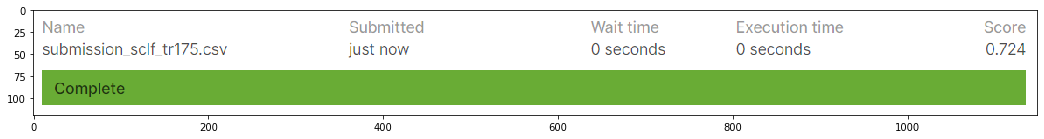

In [48]:
image = plt.imread(data_dir+'/submission_sclf_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 7.7 Voting Classifier (Without Stack Classifier + no weights)

In [49]:
# Import Voting Classifier
from mlxtend.classifier import EnsembleVoteClassifier

In [50]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2,clf3,clf4])
# Fit the train data
eclf.fit(tr_X,tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1000,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                              

# 7.7.1 Kaggle Score

In [51]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_tr175.csv', index=False)

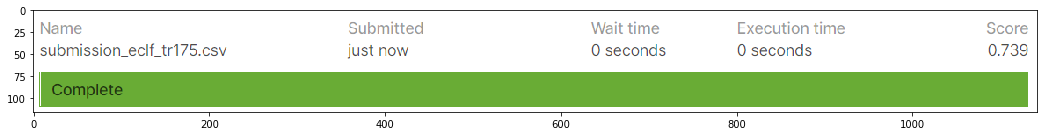

In [52]:
image = plt.imread(data_dir+'/submission_eclf_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 7.8 Voting Classifier (With Stack Classifier + no weights)

In [53]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2,clf3,clf4,sclf])
# Fit the train data
eclf.fit(tr_X,tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1000,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                              

# 7.8.1 Kaggle Score

In [54]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_stack_tr175.csv', index=False)

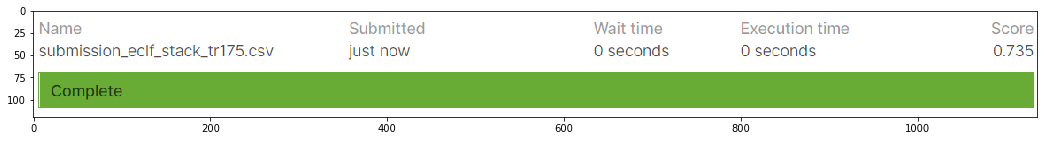

In [55]:
image = plt.imread(data_dir+'/submission_eclf_stack_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 7.9 Voting Classifier (without Stack Classifier + weights)

In [56]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4], weights=[0.3,0.3,0.2,0.2])
# Fit the train data
eclf.fit(tr_X,tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1000,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                              

 # 7.9.1 Kaggle Score

In [57]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_weights_tr175.csv', index=False)

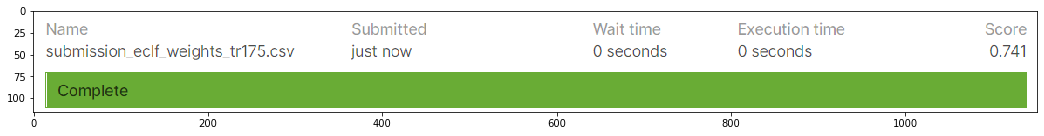

In [58]:
image = plt.imread(data_dir+'/submission_eclf_weights_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 7.10 Voting Classifier (with Stack Classifier + weights)

In [59]:
# Voting Classifier (See Docs: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4,sclf], weights=[0.3,0.3,0.05,0.05,0.3])
# Fit the train data
eclf.fit(tr_X,tr_y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=1000,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                              

# 7.10.1 Kaggle Score

In [60]:
# Create a submission file format to submit in Kaggle
temp_id = df_test['id']
eclf_csv = eclf.predict_proba(ts_X)[:,1]
eclf_df = pd.DataFrame(np.column_stack((temp_id,eclf_csv)), columns=['id','target'])
eclf_df['id'] = eclf_df['id'].astype('int32')
eclf_df.to_csv(data_dir+'/submission_eclf_stack_weights_tr175.csv', index=False)

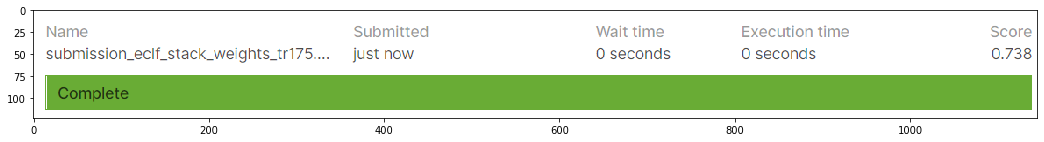

In [61]:
image = plt.imread(data_dir+'/submission_eclf_stack_weights_tr175.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

# 6. Summary of All Models

In [62]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model','Features','Hyperparameter','Test Score']
x.add_row(['knn','AF',r"{'algorithm': 'kd_tree', 'n_neighbors': 17}",0.639])
x.add_row(['Logistic Regression','AF',r"{'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}",0.718])
x.add_row(['SVC','AF',r"{'C': 0.1, 'kernel': 'linear'}",0.724])
x.add_row(['RandomForest','AF',r"{'max_depth': 2, 'n_estimators': 400}",0.663])
x.add_row(['XGBoost','AF',r"{'max_depth': 7, 'n_estimators': 300}",0.658])
x.add_row(['Stacking Classifier','AF','-',0.724])
x.add_row(['Voting Classifier(No stacking + no weights)','AF',"-",0.739])
x.add_row(['Voting Classifier(stacking + no weights)','AF',"-",0.735])
x.add_row(['Voting Classifier(no stacking + weights)','AF',"-",0.741])
x.add_row(['Voting Classifier(stacking + weights)','AF',"-",0.738])
print(x)

+---------------------------------------------+----------+-----------------------------------------------------+------------+
|                    Model                    | Features |                    Hyperparameter                   | Test Score |
+---------------------------------------------+----------+-----------------------------------------------------+------------+
|                     knn                     |    AF    |     {'algorithm': 'kd_tree', 'n_neighbors': 17}     |   0.639    |
|             Logistic Regression             |    AF    | {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'} |   0.718    |
|                     SVC                     |    AF    |            {'C': 0.1, 'kernel': 'linear'}           |   0.724    |
|                 RandomForest                |    AF    |        {'max_depth': 2, 'n_estimators': 400}        |   0.663    |
|                   XGBoost                   |    AF    |        {'max_depth': 7, 'n_estimators': 300}        |   0.6

Notation:
1. AF: All features